In [1]:
import sys
sys.path.append('../')

import hydra
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F

from models import ACTIVATION_MAP, ParallelLinear
from run_experiment import standardize_targets
from tasks import NonlinearGEOFFTask

%matplotlib inline

/home/edan/local_projects/phd_research/feature_search/notebook/../run_experiment.py:233: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='conf', config_name='defaults')


In [2]:
hydra.initialize(config_path='../conf')
config = hydra.compose(
    config_name = 'sparse_binary_geoff',
    overrides = [
        'device=cuda',
        
        # Task params
        'task.n_real_features=100',
        'task.hidden_dim=50',
        'task.sparsity=0.95',
        
        # Model params
        'model.output_dim=1',
        'model.n_layers=3',
        'model.hidden_dim=100',
        'model.activation=relu',
        '+model.n_parallel=20',
        
        # Training params
        'train.learning_rate=0.0001',
        'train.weight_decay=0.0',
        'train.standardize_cumulants=True',
    ]
)

/tmp/ipykernel_21557/3009842572.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='../conf')


In [3]:
class ParallelMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        n_parallel: int,
        n_layers: int,
        hidden_dim: int,
        activation: str = 'tanh'
    ) -> None:
        """A simplified MLP that uses parallel linear layers to get multiple outputs.
        
        Args:
            input_dim: Number of input features
            output_dim: Number of output features per parallel network
            n_parallel: Number of parallel networks
            n_layers: Number of layers (including output)
            hidden_dim: Size of hidden layers
            activation: Activation function ('relu', 'tanh', or 'sigmoid')
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_parallel = n_parallel
        
        activation_cls = ACTIVATION_MAP[activation]
        
        # Build layers
        self.layers = nn.ModuleList()
        if n_layers == 1:
            self.layers.append(ParallelLinear(input_dim, output_dim, n_parallel, bias=False))
        else:
            self.layers.append(ParallelLinear(input_dim, hidden_dim, n_parallel, bias=False))
            self.layers.append(activation_cls())
            for _ in range(n_layers - 2):
                self.layers.append(ParallelLinear(hidden_dim, hidden_dim, n_parallel, bias=False))
                self.layers.append(activation_cls())
            self.layers.append(ParallelLinear(hidden_dim, output_dim, n_parallel, bias=False))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (input_dim,)
            
        Returns:
            Output tensor of shape (n_parallel, output_dim)
        """
        param_inputs = {}
        for i in range(0, len(self.layers) - 2, 2):
            param_inputs[self.layers[i].weight] = x
            x = self.layers[i](x) # Linear layer
            x = self.layers[i + 1](x) # Activation

        param_inputs[self.layers[-1].weight] = x
        return self.layers[-1](x), param_inputs


In [4]:
task = NonlinearGEOFFTask(
    n_features = config.task.n_real_features,
    flip_rate = config.task.flip_rate,
    n_layers = config.task.n_layers,
    n_stationary_layers = config.task.n_stationary_layers,
    hidden_dim = config.task.hidden_dim if config.task.n_layers > 1 else 0,
    weight_scale = config.task.weight_scale,
    activation = config.task.activation,
    sparsity = config.task.sparsity,
    weight_init = config.task.weight_init,
)

In [5]:
# Initialize model and optimizer
model = ParallelMLP(
    input_dim = config.task.n_features,
    output_dim = config.model.output_dim,
    n_parallel = config.model.n_parallel,
    n_layers = config.model.n_layers,
    hidden_dim = config.model.hidden_dim,
    activation = config.model.activation,
).to(config.device)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

# Effectively RMSProp
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = config.train.learning_rate,
    betas = (0, 0.999),
    weight_decay = config.train.weight_decay,
)

task_iterator = task.get_iterator(1)

Total parameters: 20,100,000


In [22]:
phase_one_steps = 5000
phase_two_steps = 5000

frac_weight_change = 0.2

cumulant_mean = 0.0
cumulant_square_mean = 0.0
cumulant_gamma = 0.999

In [7]:
loss_history = []

for step in range(phase_one_steps):
    # Generate batch of data
    inputs, targets = next(task_iterator)
    inputs, targets = inputs.to(config.device), targets.to(config.device)

    features = inputs.squeeze(0)
    
    if config.train.standardize_cumulants:
        with torch.no_grad():
            targets, cumulant_mean, cumulant_square_mean = standardize_targets(
                targets, cumulant_mean, cumulant_square_mean, cumulant_gamma, step)

    # Forward pass
    outputs, param_inputs = model(features)
    outputs = outputs.squeeze(1)
    losses = (outputs - targets.squeeze()).pow(2)
    loss = losses.sum()
    loss_history.append(losses.cpu().detach().numpy())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
loss_history = np.stack(loss_history, axis=1)

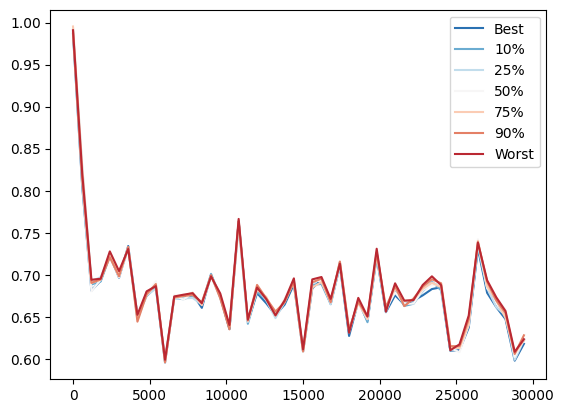

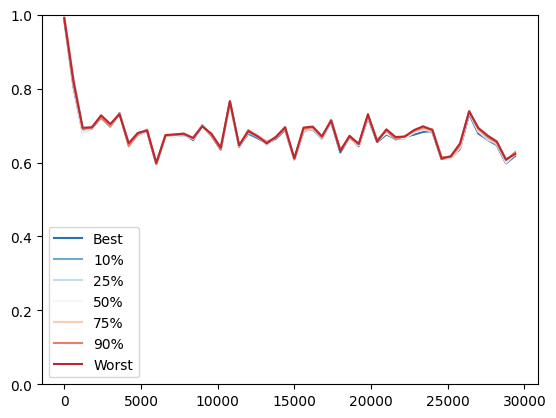

In [20]:
# Get indices sorted by average loss
avg_losses = loss_history.mean(axis=1)
sorted_indices = np.argsort(avg_losses)

# Extract indices at different percentiles
n_samples = len(sorted_indices)
best_idx = sorted_indices[0]
p10_idx = sorted_indices[int(0.1 * n_samples)]
p25_idx = sorted_indices[int(0.25 * n_samples)]
p50_idx = sorted_indices[int(0.5 * n_samples)]
p75_idx = sorted_indices[int(0.75 * n_samples)]
p90_idx = sorted_indices[int(0.9 * n_samples)]
worst_idx = sorted_indices[-1]

# Create 50 bins
n_bins = 50
bin_size = len(loss_history[0]) // n_bins
x_points = np.arange(n_bins) * bin_size

# Compute binned averages by reshaping and taking mean
selected_losses = loss_history[[best_idx, p10_idx, p25_idx, p50_idx, p75_idx, p90_idx, worst_idx]]
reshaped = selected_losses.reshape(7, n_bins, bin_size)
binned_losses = reshaped.mean(axis=2)
# Create color palette that transitions from blue to red
colors = sns.color_palette('RdBu_r', n_colors=7)

# Plot with default y limits
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.legend()
plt.show()

# Plot with y limits between 0 and 1
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [24]:
orig_weights = task.weights[-1].clone()

In [27]:
# Get total number of weights
final_layer_weights = task.weights[-1]
n_weights = final_layer_weights.numel()

# Calculate number of weights to flip (20%)
n_flip = int(0.2 * n_weights)

# Get random indices to flip
flip_indices = torch.randperm(n_weights)[:n_flip]

# Flatten weights, flip selected indices, reshape back
flat_weights = final_layer_weights.flatten()
flat_weights[flip_indices] *= -1
final_layer_weights = flat_weights.reshape_as(final_layer_weights)
task.weights[-1] = final_layer_weights

In [30]:
loss_history_2 = []

for step in range(phase_two_steps):
    # Generate batch of data
    inputs, targets = next(task_iterator)
    inputs, targets = inputs.to(config.device), targets.to(config.device)

    features = inputs.squeeze(0)
    
    if config.train.standardize_cumulants:
        with torch.no_grad():
            targets, cumulant_mean, cumulant_square_mean = standardize_targets(
                targets, cumulant_mean, cumulant_square_mean, cumulant_gamma, step)

    # Forward pass
    outputs, param_inputs = model(features)
    outputs = outputs.squeeze(1)
    losses = (outputs - targets.squeeze()).pow(2)
    loss = losses.sum()
    loss_history_2.append(losses.cpu().detach().numpy())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
loss_history_2 = np.stack(loss_history_2, axis=1)

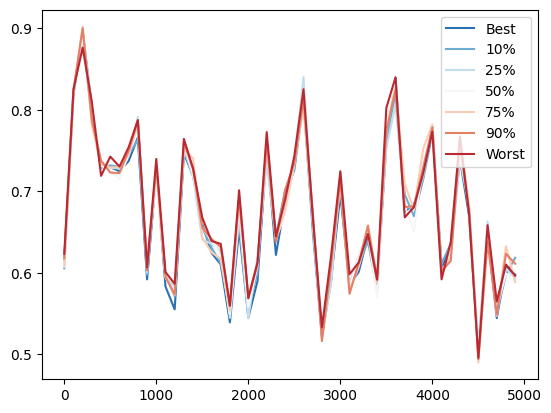

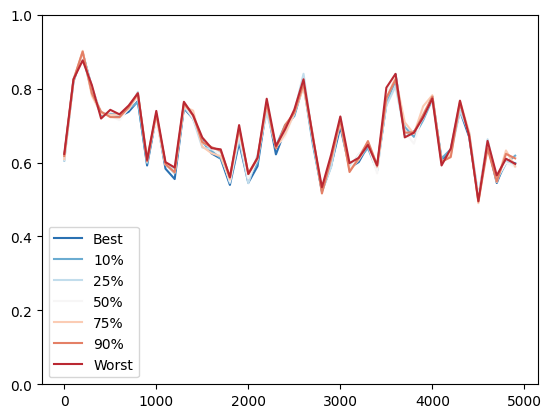

In [33]:
# Get indices sorted by average loss
avg_losses = loss_history_2.mean(axis=1)
sorted_indices = np.argsort(avg_losses)

# Extract indices at different percentiles
n_samples = len(sorted_indices)
best_idx = sorted_indices[0]
p10_idx = sorted_indices[int(0.1 * n_samples)]
p25_idx = sorted_indices[int(0.25 * n_samples)]
p50_idx = sorted_indices[int(0.5 * n_samples)]
p75_idx = sorted_indices[int(0.75 * n_samples)]
p90_idx = sorted_indices[int(0.9 * n_samples)]
worst_idx = sorted_indices[-1]

# Create 50 bins
n_bins = 50
bin_size = len(loss_history_2[0]) // n_bins
x_points = np.arange(n_bins) * bin_size

# Compute binned averages by reshaping and taking mean
selected_losses = loss_history_2[[best_idx, p10_idx, p25_idx, p50_idx, p75_idx, p90_idx, worst_idx]]
reshaped = selected_losses.reshape(7, n_bins, bin_size)
binned_losses = reshaped.mean(axis=2)
# Create color palette that transitions from blue to red
colors = sns.color_palette('RdBu_r', n_colors=7)

# Plot with default y limits
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.legend()
plt.show()

# Plot with y limits between 0 and 1
plt.figure()
sns.lineplot(x=x_points, y=binned_losses[0], color=colors[0], label='Best')
sns.lineplot(x=x_points, y=binned_losses[1], color=colors[1], label='10%')
sns.lineplot(x=x_points, y=binned_losses[2], color=colors[2], label='25%')
sns.lineplot(x=x_points, y=binned_losses[3], color=colors[3], label='50%')
sns.lineplot(x=x_points, y=binned_losses[4], color=colors[4], label='75%')
sns.lineplot(x=x_points, y=binned_losses[5], color=colors[5], label='90%')
sns.lineplot(x=x_points, y=binned_losses[6], color=colors[6], label='Worst')
plt.ylim(0, 1)
plt.legend()
plt.show()
